In [1]:
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd
from numpy import dot
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as ss
import json
import pathlib
from pycytominer import aggregate, normalize

%matplotlib inline  

In [2]:
# Set data input folder
# Download files described in README.md to this folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)
if not os.path.exists(os.path.join(output_folder,"figure_panels")):
    os.makedirs(os.path.join(output_folder,"figure_panels"), exist_ok=True)

In [3]:
# Load barcodes used in experiment
guide_df = pd.read_csv("SABER_Library_ngt_Included_Oligo_Sequences_Assiged.csv")
all_guides_list = list(guide_df.iloc[:,4].unique())

count_df = pd.read_csv(os.path.join(output_folder,'HeLa_SABER_screen_SABER_arm_cell_count.csv.gz'))
count_df = count_df.rename(columns={'Metadata_Foci_Barcode_MatchedTo_GeneCode':'gene','Metadata_Foci_Barcode_MatchedTo_Barcode':'barcode'})
count_df['n_guides'] = np.nan

count_df

,gene,barcode,Cell_Count,n_guides
0,MFN2,AAATAAGAGACACATGGCTG,14856,NaN
1,AP3S1,CTTGCAGAAATGGTGATGGG,13557,NaN
2,NDUFAF7,GACACCTTTCATATACACTG,11946,NaN
3,SLC27A2,ATTCACGGATGTATTGTGGC,10727,NaN
4,DENND4B,TGCCAAGGGTGTTGTATGAG,10451,NaN
...,...,...,...,...
2395,RPS24,TGACCAACCGACTACTTCAG,85,NaN
2396,TPT1,TTTCGGTACCTTCGCCCTCG,83,NaN
2397,RPL35A,GCGGGGTCTCCGGAACCAAA,76,NaN
2398,GSR,TGGGCGGGTCCCGAATACCA,59,NaN


In [5]:
count_df_1000 = count_df.query('Cell_Count > 1000')
all_guides_list_1000 = list(count_df_1000.barcode.unique())
for guide in all_guides_list_1000:
    gene = list(count_df_1000.loc[count_df_1000['barcode']== guide,'gene'])[0]
    df_temp = count_df_1000.query('gene == @gene')
    count_df_1000.loc[count_df_1000['barcode']== guide,'n_guides'] = len(df_temp)
    
count_df_1000_4_guides = count_df_1000.query('n_guides >= 4')
selected_genes_list = list(count_df_1000_4_guides.gene.unique())
selected_guides_list = list(count_df_1000_4_guides.barcode.unique())
count_df_1000_4_guides

,gene,barcode,Cell_Count,n_guides
0,MFN2,AAATAAGAGACACATGGCTG,14856,4.0
1,AP3S1,CTTGCAGAAATGGTGATGGG,13557,4.0
2,NDUFAF7,GACACCTTTCATATACACTG,11946,4.0
3,SLC27A2,ATTCACGGATGTATTGTGGC,10727,4.0
4,DENND4B,TGCCAAGGGTGTTGTATGAG,10451,4.0
...,...,...,...,...
1896,PSMB5,TAGCGGTCTCTCCAACACGC,1013,4.0
1897,COX7C,TGTTGGGCCAGAGCATCCGG,1012,4.0
1898,RPL22L1,CGGGAGAAGGTTAAAGTCAA,1012,4.0
1899,VDAC2,ACGCGCGCAAGTCTGTCCGT,1004,4.0


In [7]:
cp498_guide_profiles_df = pd.read_csv('../outputs/20240202_6W_CP498_SABER_Pilot_HeLa_SABER_only_guide_normalized_merged_feature_select_median_ALLWELLS.csv.gz')
selected_features = list(cp498_guide_profiles_df.columns)
len(selected_features)

3074

In [7]:
# Load and subset the single-cell profiles per plate for M059K plates
plates = ['SABER_Plate_1','SABER_Plate_2','SABER_Plate_4']
chunksize = 10 ** 5

df_plate_list = []
for plate in plates:
    filename = f'20240202_6W_CP498_SABER_Pilot_HeLa_SABER_only_single_cell_profiles_ALLBATCHES___{plate}___ALLWELLS.csv.gz' 
    chunks = []
    with pd.read_csv(filename ,usecols=selected_features ,chunksize=chunksize) as reader:
        for chunk in reader:
            sub_chunk = chunk[chunk['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(selected_genes_list)]
            chunks.append(sub_chunk)
            print(chunk.shape,f'of plate {plate}')
            print(sub_chunk.shape,f'of plate {plate}')
    df = pd.concat(chunks)
    #df.to_csv(os.path.join(output_folder,f'20240202_6W_CP498_SABER_Pilot_HeLa_single_cell_profiles_ALLBATCHES___{plate}_ALLWELLS.csv.gz'),index = False)
    df_plate_list.append(df)

single_cell_df = pd.concat(df_plate_list)
single_cell_df

(100000, 3074) of plate SABER_Plate_1
(72710, 3074) of plate SABER_Plate_1
(100000, 3074) of plate SABER_Plate_1
(72444, 3074) of plate SABER_Plate_1
(100000, 3074) of plate SABER_Plate_1
(72535, 3074) of plate SABER_Plate_1
(100000, 3074) of plate SABER_Plate_1
(72069, 3074) of plate SABER_Plate_1
(100000, 3074) of plate SABER_Plate_1
(72999, 3074) of plate SABER_Plate_1
(100000, 3074) of plate SABER_Plate_1
(72286, 3074) of plate SABER_Plate_1
(100000, 3074) of plate SABER_Plate_1
(72755, 3074) of plate SABER_Plate_1
(100000, 3074) of plate SABER_Plate_1
(72885, 3074) of plate SABER_Plate_1
(100000, 3074) of plate SABER_Plate_1
(72733, 3074) of plate SABER_Plate_1
(100000, 3074) of plate SABER_Plate_1
(72701, 3074) of plate SABER_Plate_1
(100000, 3074) of plate SABER_Plate_1
(72767, 3074) of plate SABER_Plate_1
(100000, 3074) of plate SABER_Plate_1
(72674, 3074) of plate SABER_Plate_1
(100000, 3074) of plate SABER_Plate_1
(72783, 3074) of plate SABER_Plate_1
(100000, 3074) of plate S

,Metadata_Foci_Barcode_MatchedTo_GeneCode,Metadata_Foci_Barcode_MatchedTo_Barcode,Cells_AreaShape_CentralMoment_0_1,Cells_AreaShape_CentralMoment_0_3,Cells_AreaShape_CentralMoment_1_0,Cells_AreaShape_CentralMoment_1_1,Cells_AreaShape_CentralMoment_1_2,Cells_AreaShape_CentralMoment_1_3,Cells_AreaShape_CentralMoment_2_1,Cells_AreaShape_CentralMoment_2_3,...,Nuclei_Texture_SumEntropy_PRSP6_10_01_256,Nuclei_Texture_SumVariance_NfKb_10_01_256,Nuclei_Texture_SumVariance_Syto9_10_00_256,Nuclei_Texture_SumVariance_Syto9_10_01_256,Nuclei_Texture_SumVariance_Syto9_10_02_256,Nuclei_Texture_SumVariance_Syto9_10_03_256,Nuclei_Texture_SumVariance_TDP43_10_01_256,Nuclei_Texture_SumVariance_TDP43_10_02_256,Nuclei_Texture_SumVariance_TDP43_10_03_256,Nuclei_Texture_Variance_Syto9_10_01_256
0,ALG5,AGCAGTTGTAAATGCAACGA,-2.572200e-12,126840.00,4.767700e-12,-9621.000,33544.00,-3995500.0,-396420.000,-3.657100e+07,...,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.000,0.000,0.0000,0.00000
1,MAP1S,CGTACTCCAGGAATTCGCAC,-1.385600e-13,-608.71,8.881800e-16,42.163,-3415.40,4626.4,-98.012,-1.072500e+04,...,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.000,0.000,0.0000,0.00000
3,SPIDR,AAGATCCGGACAGTGTCCTG,0.000000e+00,3978.00,0.000000e+00,-890.000,-1023.50,-43422.0,-1099.000,1.634900e+04,...,0.0000,0.0000,0.0000,0.00000,0.0000,0.0000,0.000,0.000,0.0000,0.00000
4,MRPS15,CTAGTACCCGGGCTGCCGGG,-1.282500e-12,-16472.00,1.421100e-13,3035.300,-44085.00,1006500.0,-12654.000,-3.498200e+06,...,2.6258,5.2222,15.4470,3.25000,6.4336,1.4722,17.806,15.062,5.5556,9.68750
5,TOMM22,CCGGACGAATTGCTCCCGAA,8.753900e-12,-5626300.00,-1.556100e-12,-218890.000,-21218.00,-157080000.0,-651790.000,-3.616800e+08,...,2.7878,10.4830,4.1406,8.28930,12.1180,2.4738,12.651,15.740,12.6340,4.47550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328100,MTIF2,CCCCGCATTTACCGTAAGTG,2.188500e-12,9533700.00,-1.435300e-12,175630.000,3200700.00,167740000.0,-112300.000,1.665900e+09,...,3.4890,16.6870,5.2652,2.86250,5.6461,7.9870,69.064,55.138,46.4130,2.11900
2328102,COPG2,ACCTGCCAGATAGAGCGAAT,1.005400e-12,81118.00,2.256000e-12,10882.000,710.78,1166800.0,-117170.000,-1.140100e+07,...,2.9294,17.8600,3.5056,4.03200,4.7792,1.6523,28.735,31.971,17.7260,2.87900
2328104,UFM1,ACAAGTGCAATTATTACCAA,-1.684700e-11,-529890.00,-1.146800e-11,-27539.000,2135000.00,-10273000.0,418690.000,1.710800e+08,...,2.8767,7.8010,4.5531,7.01140,5.8739,5.9638,35.259,46.949,33.5070,3.82270
2328105,MLH1,AGAAATCAGTCCCCAGAATG,4.519100e-12,-798510.00,1.399800e-12,-34210.000,482220.00,-15205000.0,85834.000,-4.332400e+07,...,3.1911,7.1622,8.4109,5.42120,7.3584,4.6468,23.646,25.999,25.8070,3.70470


In [ ]:
subsample_ns = [100,200,300,400,500,750,1000]
subsample_dfs_dictionary = {} 
for n in subsample_ns:
    df_list_n = []
    for guide in selected_guides_list:
        df_temp = single_cell_df.query('Metadata_Foci_Barcode_MatchedTo_Barcode == @guide')
        if len(df_temp)<n:
            continue
        df_temp_sample = df_temp.sample(n=n,random_state=42)
        df_list_n.append(df_temp_sample)
    df_n = pd.concat(df_list_n)
    aggregate_df_n = aggregate(
        population_df=df_n,
        strata=['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode'],
        features='infer',
        operation='median'
    )
    subsample_dfs_dictionary[n]=aggregate_df_n
    aggregate_df_n.to_csv(f'CP498_SABER_arm_subsampled_aggregated_{n}_cells.csv',index=False)
    print(f'profiles at {n} representation level are aggregated.')
subsample_dfs_dictionary[subsample_ns[0]]

In [13]:
# Load the subsampled, aggregated profiles from the previous step if you are starting from here
# These files are not stored in the Github repository - see the README for download instructions

subsample_ns = [100,200,300,400,500,750,1000]
subsample_dfs_dictionary = {} 
for n in subsample_ns:
    aggregate_df_n = pd.read_csv(f'CP498_SABER_arm_subsampled_aggregated_{n}_cells.csv')
    subsample_dfs_dictionary[n] = aggregate_df_n

In [14]:
def cosine_to_df(df_temp, cosine_array, i):
    cosine_list = cosine_array[i]
    gene_list = list(df_temp.index)
    cosine_df = pd.DataFrame(index=gene_list)
    cosine_df['cosine'] = cosine_list
    cosine_df = cosine_df.sort_values('cosine',ascending=False)   
    return cosine_df

def ap_from_cosine_df(cosine_df,gene,n=10):    
    #print(cosine_df.iloc[:20])
    index_list = list(cosine_df.index)
    boolean = [1 if  i == gene else 0 for i in index_list ]
    grades_list=[]
    for i in range(2,n+2):
        pre_grade = sum(boolean[1:i])/(i-1)
        grades_list.append(pre_grade*boolean[i-1])
    return sum(grades_list)/3

def calculate_map(df_guide, gene):
    df_temp = df_guide.query("Metadata_Foci_Barcode_MatchedTo_GeneCode == 'nontargeting' | Metadata_Foci_Barcode_MatchedTo_GeneCode == @gene")
    df_temp = df_temp.drop(['Metadata_Foci_Barcode_MatchedTo_Barcode'],axis=1)
    df_temp = df_temp.set_index("Metadata_Foci_Barcode_MatchedTo_GeneCode")
    #print(df_temp)
    ap_list = []
    cosine_array = cosine_similarity(df_temp)
    for guide in range(4):
        cosine_df = cosine_to_df(df_temp, cosine_array, guide)
        #print(cosine_df[:10])
        guide_ap = ap_from_cosine_df(cosine_df,gene,10)
        ap_list.append(guide_ap)
    return np.mean(ap_list)

In [15]:
# calculate the mAP values
rep_results = {}
for n in subsample_ns:
    genes_list = list(subsample_dfs_dictionary[n].Metadata_Foci_Barcode_MatchedTo_GeneCode.unique())
    map_list = []
    for i in range(len(genes_list)):
        gene = genes_list[i]
        gene_map = calculate_map(subsample_dfs_dictionary[n], gene)
        map_list.append([gene, gene_map])
    rep_results[n] = map_list

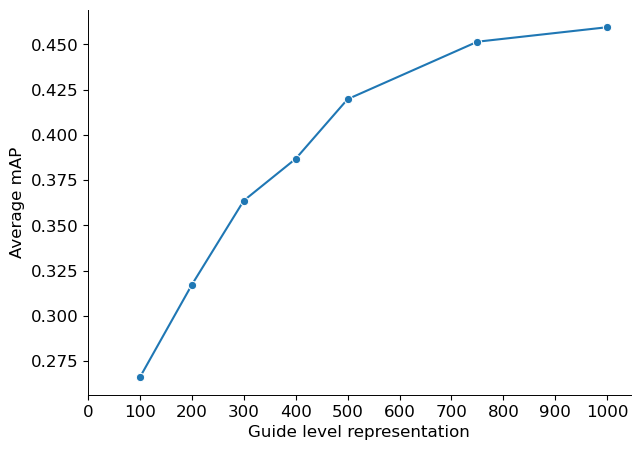

In [16]:
ys = []
for n in subsample_ns:
    y = [i[1] for i in rep_results[n] if i[1]]
    ys.append(np.mean(y))

mpl.rc('axes', linewidth=0.7)
mpl.rc('ytick', labelsize=12)
mpl.rc('xtick', labelsize=12)

fig, ax = plt.subplots(figsize=(7,5))

ax = sns.lineplot(x=subsample_ns, y=ys, errorbar=None, style=1, markers=True, legend=False)
ax.set_title('',size=14)
ax.set_xlabel('Guide level representation',size=12)
ax.set_ylabel('Average mAP',size=12)
ax.set_xticks(range(0,1001,100))

# draw reference lines for screen data
#plt.axvline(x=117, color = 'orange', linestyle='dashed', label='A549')
#plt.text(160,.58,'-- A549',color='orange')
#plt.axvline(x=125, color = 'red', linestyle='dashed', label='HeLa DMEM')
#plt.text(160,.56,'-- HeLa DMEM',color='red')
#plt.axvline(x=93, color = 'brown', linestyle='dashed', label='HeLa HPLM')
#plt.text(160,.6,'-- HeLa HPLM',color = 'brown')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(output_folder,'figure_panels','CP498_SABER_arm_subsample_average_mAP.png'),dpi = 300,bbox_inches='tight')
plt.show()